In [53]:
%load_ext autoreload
%autoreload 2

In [45]:
import numpy as np
import pandas as pd
import itertools
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error


In [8]:
x_path = "/homes/gws/sqhang/proj/2024_sqhang_Transductive-bandits/data/tf_bind_8-x-0.npy"
x_arr = np.load(x_path, allow_pickle=True)
print(x_arr.shape)
print(x_arr[0, :])
y_path = "/homes/gws/sqhang/proj/2024_sqhang_Transductive-bandits/data/tf_bind_8-y-0.npy"
y_arr = np.load(y_path, allow_pickle=True)
print(y_arr.shape)
print(y_arr[0])

(65792, 8)
[0 0 0 0 0 0 0 0]
(65792, 1)
[0.5247495]


### Train/test split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size=0.2, random_state=42)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (52633, 8)
Shape of x_test: (13159, 8)
Shape of y_train: (52633, 1)
Shape of y_test: (13159, 1)


### Helper functions

In [12]:
def compute_correlations(y_true, y_pred):
    """
    Compute Pearson and Spearman correlations between the true and predicted values.
    
    Parameters:
    - y_true: array-like, true target values
    - y_pred: array-like, predicted target values
    
    Returns:
    - A dictionary containing Pearson and Spearman correlation coefficients
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    pearson_corr, _ = pearsonr(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)
    
    return {'Pearson': pearson_corr, 'Spearman': spearman_corr}

### Fit a naive linear model

In [13]:
model = LinearRegression()
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

train_correlations = compute_correlations(y_train, y_train_pred)
print("Training Correlations:", train_correlations)

test_correlations = compute_correlations(y_test, y_test_pred)
print("Testing Correlations:", test_correlations)

Training Correlations: {'Pearson': 0.015199637183468109, 'Spearman': 0.014321767862951336}
Testing Correlations: {'Pearson': -0.011014614051512528, 'Spearman': -0.00888572997442289}


Whoops! Barely no correlations. Let's try with a more meaningful featurization.

### Kmer Linear Regression

In [14]:
def make_kmer_list(k, alphabet="ACGT", upto=False):
    """Generate sorted list of k-mers for each k up to the given k, considering reverse complements."""
    kmer_dict = {}
    if upto:
        range_k = range(1, k + 1)
    else:
        range_k = [k]
    for current_k in range_k:
        kmer_set = set()
        for kmer_tuple in itertools.product(alphabet, repeat=current_k):
            kmer = ''.join(kmer_tuple)
            rev_kmer = ''.join(reversed([{'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}[x] for x in kmer]))
            kmer_set.add(min(kmer, rev_kmer))
        kmer_dict[current_k] = sorted(kmer_set)
    # Flatten dictionary into a list while preserving order by k-mer length
    kmer_list = [kmer for sublist in range_k for kmer in kmer_dict[sublist]]
    return kmer_list, kmer_dict

In [15]:
### Counting k-mers
def count_kmers(sequences, k, normalize=None, upto=False):
    """Count k-mers in sequences for all lengths up to k if 'upto' is True, and optionally normalize the counts."""
    alphabet = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
    num_sequences = sequences.shape[0]
    kmer_list, kmer_dict = make_kmer_list(k, alphabet="ACGT", upto=upto)
    kmer_index = {kmer: idx for idx, kmer in enumerate(kmer_list)}
    kmer_matrix = np.zeros((num_sequences, len(kmer_list)), dtype=float)  # Changed dtype to float

    # Convert sequences to strings and count k-mers
    for i in range(num_sequences):
        sequence = ''.join(alphabet[b] for b in sequences[i])
        for current_k, kmers in kmer_dict.items():
            for j in range(len(sequence) - current_k + 1):
                kmer = sequence[j:j+current_k]
                rev_kmer = ''.join(reversed([{'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}[x] for x in kmer]))
                canonical_kmer = min(kmer, rev_kmer)
                if canonical_kmer in kmer_index:
                    kmer_matrix[i, kmer_index[canonical_kmer]] += 1

    if normalize:
        if normalize == "frequency":
            # Normalize separately for each k-length group
            for current_k, kmers in kmer_dict.items():
                indices = [kmer_index[kmer] for kmer in kmers]
                sums = kmer_matrix[:, indices].sum(axis=1, keepdims=True)
                kmer_matrix[:, indices] /= np.maximum(1, sums)
        elif normalize == "unitsphere":
            for current_k, kmers in kmer_dict.items():
                indices = [kmer_index[kmer] for kmer in kmers]
                norms = np.linalg.norm(kmer_matrix[:, indices], axis=1, keepdims=True)
                kmer_matrix[:, indices] /= np.maximum(1e-10, norms)

    return kmer_matrix

In [16]:
k = 5
x_train_kmer = count_kmers(x_train, k, normalize='frequency', upto=True)
print(x_train_kmer.shape)

(52633, 692)


In [17]:
k = 5
x_test_kmer = count_kmers(x_test, k, normalize='frequency', upto=True)
print(x_test_kmer.shape)

(13159, 692)


In [20]:
model_kmer = LinearRegression()
model_kmer.fit(x_train_kmer, y_train)

y_train_pred_kmer = model_kmer.predict(x_train_kmer)
y_test_pred_kmer = model_kmer.predict(x_test_kmer)

kmer_train_correlations = compute_correlations(y_train, y_train_pred_kmer)
print("Training Correlations:", kmer_train_correlations)

kmer_test_correlations = compute_correlations(y_test, y_test_pred_kmer)
print("Testing Correlations:", kmer_test_correlations)

Training Correlations: {'Pearson': 0.8651149965973624, 'Spearman': 0.8088248800436516}
Testing Correlations: {'Pearson': 0.8667021527647701, 'Spearman': 0.8042851828570469}


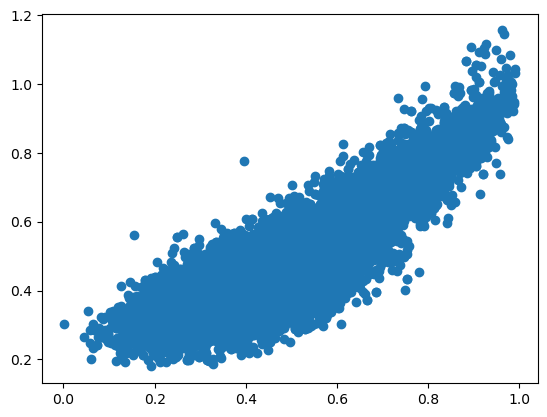

In [48]:
plt.scatter(y_test, y_test_pred_kmer)
plt.show()

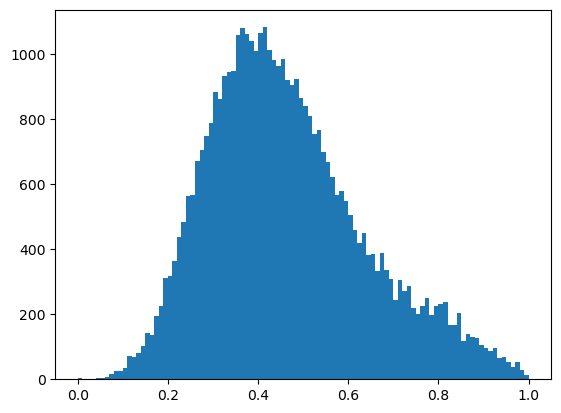

In [52]:
plt.hist(y_train, bins=100)
plt.show()

### Kmer Kernel Methods

In [22]:
model_kmer_krr = KernelRidge(alpha=1.0, kernel='rbf', gamma=0.1)

model_kmer_krr.fit(x_train_kmer, y_train)

KernelRidge(alpha=1.0, gamma=0.1, kernel='rbf')

In [23]:
y_train_pred_kmer_krr = model_kmer_krr.predict(x_train_kmer)
y_test_pred_kmer_krr = model_kmer_krr.predict(x_test_kmer)

# Compute correlations or other performance metrics
kmer_train_correlations_krr = compute_correlations(y_train, y_train_pred_kmer_krr)
kmer_test_correlations_krr = compute_correlations(y_test, y_test_pred_kmer_krr)

print("Training Correlations (KRR):", kmer_train_correlations_krr)
print("Testing Correlations (KRR):", kmer_test_correlations_krr)

Training Correlations (KRR): {'Pearson': 0.8698403407591941, 'Spearman': 0.8153968202744548}
Testing Correlations (KRR): {'Pearson': 0.8712696485314264, 'Spearman': 0.8101305844413605}


In [ ]:
# Hyperparameter search code to run if have time
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 1, 10, 100],
              'gamma': np.logspace(-4, 1, 6)}

grid_search = GridSearchCV(KernelRidge(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(x_train_kmer, y_train)

best_krr_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

### Kmer XGBoost Methods

In [25]:
import xgboost as xgb

In [40]:
x_train_kmer, x_val_kmer, y_train, y_val = train_test_split(
    x_train_kmer, y_train, test_size=0.2, random_state=42
)
print(x_train_kmer.shape)
print(x_val_kmer.shape)

(42106, 692)
(10527, 692)


In [41]:
dtrain = xgb.DMatrix(x_train_kmer, label=y_train)
dval = xgb.DMatrix(x_val_kmer, label=y_val)
dtest = xgb.DMatrix(x_test_kmer, label=y_test)

In [42]:
params = {
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

In [43]:
num_boost_round = 5000
evals = [(dtrain, 'train'), (dval, 'validation')]
bst = xgb.train(params, dtrain, num_boost_round, evals=evals, early_stopping_rounds=10)

[0]	train-rmse:0.16184	validation-rmse:0.16177
[1]	train-rmse:0.15118	validation-rmse:0.15143
[2]	train-rmse:0.14179	validation-rmse:0.14244
[3]	train-rmse:0.13367	validation-rmse:0.13466
[4]	train-rmse:0.12653	validation-rmse:0.12788
[5]	train-rmse:0.12028	validation-rmse:0.12198
[6]	train-rmse:0.11491	validation-rmse:0.11693
[7]	train-rmse:0.11019	validation-rmse:0.11261
[8]	train-rmse:0.10611	validation-rmse:0.10887
[9]	train-rmse:0.10249	validation-rmse:0.10558
[10]	train-rmse:0.09937	validation-rmse:0.10280
[11]	train-rmse:0.09667	validation-rmse:0.10035
[12]	train-rmse:0.09426	validation-rmse:0.09832
[13]	train-rmse:0.09221	validation-rmse:0.09656
[14]	train-rmse:0.09031	validation-rmse:0.09498
[15]	train-rmse:0.08871	validation-rmse:0.09368
[16]	train-rmse:0.08725	validation-rmse:0.09246
[17]	train-rmse:0.08602	validation-rmse:0.09144
[18]	train-rmse:0.08482	validation-rmse:0.09054
[19]	train-rmse:0.08381	validation-rmse:0.08973
[20]	train-rmse:0.08279	validation-rmse:0.08898
[2

In [44]:
y_train_pred_xgb = bst.predict(dtrain)
y_test_pred_xgb = bst.predict(dtest)

# Assuming compute_correlations is defined to compute your metric of interest
xgb_train_correlations = compute_correlations(y_train, y_train_pred_xgb)
xgb_test_correlations = compute_correlations(y_test, y_test_pred_xgb)

print("Training Correlations (XGBoost):", xgb_train_correlations)
print("Testing Correlations (XGBoost):", xgb_test_correlations)

Training Correlations (XGBoost): {'Pearson': 0.9937048679572801, 'Spearman': 0.9918885296387072}
Testing Correlations (XGBoost): {'Pearson': 0.9413444233301491, 'Spearman': 0.9140121527133677}


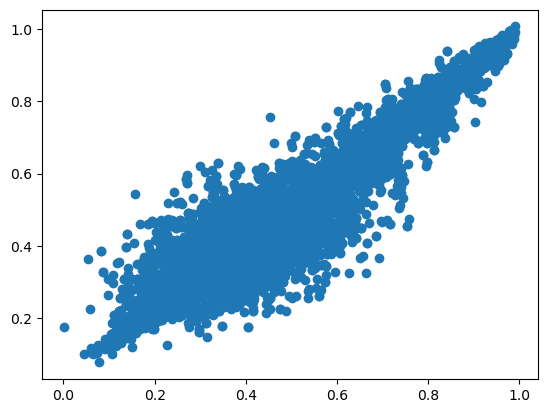

In [47]:
plt.scatter(y_test, y_test_pred_xgb)
plt.show()